## Import Required Libraries

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

## Collecting Data

In [ ]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip

!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [ ]:
!head -20 data/words.txt

## Sorting the Dataset

Selects the required rows of data

In [ ]:
base_path = "data"

# initialize an empty list to hold the set of words in the dataset
words_list = list()

words = open(f"{base_path}/words.txt", "r").readlines()
# iterate through each row of the dataset
for line in words:
    # if the row starts with '#' --> ignored
    if line[0] == "#":
        continue
    # if there is no "err" data --> put into the list 'words_list'
    if line.split(" ")[1] != "err": 
        words_list.append(line)

len(words_list)
np.random.shuffle(words_list)

note:

example line

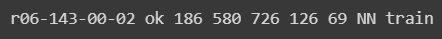

The dataset will be split with a ratio of 90:5:5 (train:validation:test).

In [ ]:
# calculate the index to split the train data  
split_index = int(0.9 * len(words_list))
# split the data based on the previous index
train_data = words_list[:split_index]
test_data = words_list[split_index:]

# calculate the index to split the test data into test data and validation data
val_split_index = int(0.5 * len(test_data))
# split the data based on the previous index
validation_data = test_data[:val_split_index]
test_data = test_data[val_split_index:]

assert len(words_list) == len(train_data) + len(validation_data) + len(test_data)

print(f"Total training samples: {len(train_data)}")
print(f"Total validation samples: {len(validation_data)}")
print(f"Total test samples: {len(test_data)}")

## Data input pipeline

1. Preparing the path of the image to be used

In [ ]:
base_image_path = os.path.join(base_path, "words")

def get_image_paths_and_labels(data):
    # initialize the list for paths and corrected data 
    paths = []
    corrected_data = []
    for (i, file_line) in enumerate(data):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

       # each line will have the following format:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        part1 = image_name.split("-")[0]
        part2 = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, part1, part1 + "-" + part2, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_data.append(file_line.split("\n")[0])

    return paths, corrected_data

train_img_paths, train_labels = get_image_paths_and_labels(train_data)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_data)
test_img_paths, test_labels = get_image_paths_and_labels(test_data)

2. Preparing the actual label

In [ ]:
# initialize the list for the label
train_labels_cleaned = []

# initialize set characters to hold characters
# using set to avoid double data
characters = set()

# initialize a variable to hold the maximum length of the vocabulary
max_len = 0

# iterate for each label in train labels
for label in train_labels:
    # split labels based on spaces
    label = label.split(" ")[-1].strip()
    # put the characters in the label into the characters set
    for char in label:
        characters.add(char)

      # update the max_len value
    max_len = max(max_len, len(label))
    # add labels to the list
    train_labels_cleaned.append(label)

# the characters in the set are sorted
characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

3. Do the same for validation and test labels

In [ ]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

## Building characters from vocabulary 

Example: "me" and "you", the character vocabulary will be {a, k, m, u}

In [ ]:
# To customize the data
AUTOTUNE = tf.data.AUTOTUNE

# Map characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Map integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

## Adjusting Size Without Distortion

Uniformizing the image size is necessary to divide the training dataset into smaller groups.

In [ ]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)
    # check how much padding is needed
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only needed if you want the same amount of padding on both sides
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

## Combining all utilities to prepare the dataset

- image preprocessing
- vectorize labels
- process image labels
- prepare dataset

In [ ]:
# initialize batch size, padding, image length and width
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

# function for image preprocessing
def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

# function to convert label into vector form
def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

# function to process image labels
def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

# function to prepare the dataset
def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

## Preparing the tf.data.Dataset object 

In [ ]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

## Visualize multiple sample datasets

In [ ]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

## Model

Our model will use CTC loss as the endpoint of the layer

In [ ]:
# Create a CTCLayer class
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # Returns the prediction calculation
        return y_pred


def build_model():
    # Entering input to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First convolution
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second convolution
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Should use 2 max poops with pool size and stride 2.
    # Therefore, the downsampled feature map is 4x smaller.
    # The number of filters in the last layer is 64. 
    # Perform reshape before passing the output to the RNN model part
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNN
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # The +2 is to account for two special tokens introduced by CTC loss.
    # Recommendations from: https://git.io/J0eXP.
    x = hard.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Append the CTC layer to calculate the CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer
    opt = keras.optimizers.Adam()

    # Compile the model, then return
    model.compile(optimizer=opt)
    return model


# build the model
model = build_model()
model.summary()

## Evaluation Metrics

1. Separate images and validation labels

In [ ]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

2. Create a function to monitor edit distance

In [ ]:
# Create a function to calculate distance
def calculate_edit_distance(label, prediction):
    # Take 1 batch and convert labels to sparse tensor
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype = tf.int64)

    # Make predictions and convert them to sparse tensor
    input_len = np.ones(prediction.shape[0]) * prediction.shape[1]
    prediction_decoded = keras.backend.ctc_decode(
        prediction, input_length = input_length, greedy = True
    )[0][0][:, :max_len]
    prediction_sparse = tf.cast(
        tf.sparse.from_dense(prediction_decoded), dtype = tf.int64
    )

    # Calculate each edit distance and make an average
    edit_distance = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize = False
    )
    return tf.reduce_mean(edit_distance)


class EditSpacingCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs = None):
        edit_distance = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            prediction = self.model_prediction.predict(validation_images[i])
            edit_distance.append(calculate_edit_distance(label, prediction).numpy())

        print(
            f "Average edit distance for epoch {epoch + 1}: {np.mean(edit_distance):.4f}"
        )


## Training

In [ ]:
epochs = 100
model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train model
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

## Prediction Result

In [1]:
# Function to predict
